**University:** NOVA Information Management School<br/>
**Program:** Master’s Degree Program in Data Science and Advanced Analytics<br/>
**Academic Year:** 2022/2023

```
============== Students: ==============
Iryna Savchuk (m20211310@novaims.unl.pt)
Cátia Sofia Pereira Parrinha (m20201320@novaims.unl.pt)
Giulia Bovenga (m20221637@novaims.unl.pt)
Hubert Oberhauser (m20220628@novaims.unl.pt)
Leo Allgaier (m20220635@novaims.unl.pt)
=======================================
```

# Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, Model, layers, initializers, regularizers, optimizers, metrics 

import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

# Import Clean Dataset

**Data Source**
*   Clean data to perform model training can be downloaded from here: [datasets.zip](https://drive.google.com/file/d/1xMF-lupg9UX-UZUD6NlC2h-Ao08gQ6f3/view?usp=sharing)

This dataset was saved in google drive in the following path: "/content/gdrive/MyDrive/DL_Project/"

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/gdrive/MyDrive/DL_Project/"
main_folder, training_folder, validation_folder, testing_folder = "datasets/", "train/", "validation/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/gdrive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'datasets.zip', 'datasets.zip')
    # Extract files
    zip_ = zipfile.ZipFile('datasets.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = "/content/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File transfer completed in 2.083 seconds


# List of parameters

The first parameters regarding our images:
* Resize the image from 500 to 128.
* As all images have the same shape, we do not need to crop them. <br>
* We will work with color images. <br>
* Batch size of 64, the number of batches will be loaded iteration after iteration that will train the gradient descent, em general we got a good performance. <br>
* As a multi-class classification model that will return three different classes, the lebel_mode must be categorical. <br>
* Randomization of the order of the instances set as true ensures that each minibatch represents the whole set of classes. <br>
* We do not need to use validation_split, was our original dataset already have this split.


In [4]:
image_size=(128, 128)  
crop_to_aspect_ratio=False 
color_mode='rgb'  
batch_size=64  
label_mode="categorical"  
shuffle=True  
seed=0  

# Create train, validation and test datasets

In [5]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_validation = image_dataset_from_directory(path + main_folder + validation_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


We can check 
* The [Batch Size, Height, Width, Color depth], from the first image, the first two pixels, of the first channel. <br>
* The first five values from the vector. <br>
* and the balance of our target.


In [6]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])  
print("\nSample of y_train:", batch_y_train[0:5])  
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))  

(64, 128, 128, 3) (64, 3)

Sample of x_train: tf.Tensor(
[[ 99.26709   99.308105]
 [107.84375  138.55054 ]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)
Sample average of y_train: tf.Tensor(0.33333334, shape=(), dtype=float32)


We have a batch of 64 color images of a size 128x128, stored in rank-3 tensor.
We verify that our target is balanced with 33% for each one of the three classes.

# Augmentation

Since our dataset is small, Augmentation should improve the training data's quality and diversity, making the models more robust and more prompt to generalize and avoid overfitting <br>
We will generate more training data, by a random of transformation like flip, rotation, zoom, contrast, brightness, and translation.

In [7]:
augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.3),
                           layers.RandomBrightness(factor=0.3),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")

In [8]:
def show_augmented_sample_batch(batch_x, augmentation_pipe, trials=4, fig_size=(10, 6)):
    # Plot the images
    _, axs = plt.subplots(len(batch_x), trials + 1, figsize=(10, 6), layout='constrained')
    for i, img in enumerate(batch_x):
        axs[i, 0].imshow(tf.cast(img, tf.int32))
        axs[i, 0].set_title("Original image", size=8)
        for t in range(trials):
            # Pass through the augmentation pipeline
            augmented_i = augmentation_pipe(img, training=True)
            axs[i, t+1].imshow(tf.cast(augmented_i, tf.int32))
            axs[i, t+1].set_title("Transformed image#{}".format(t), size=8)

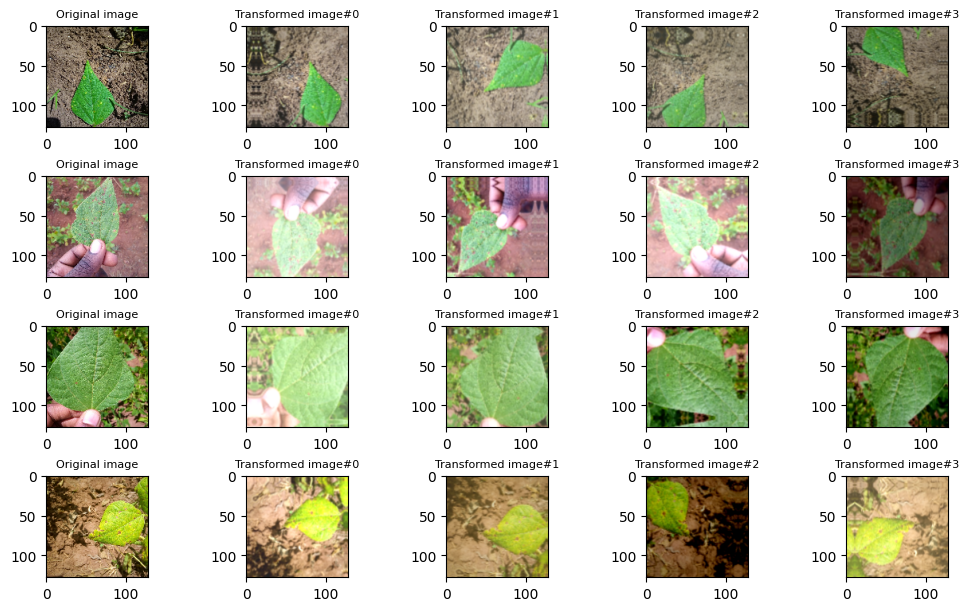

In [9]:
show_augmented_sample_batch(batch_x_train[0:4], augmentation_pipe=augmentation)

These are some examples from the previous transformation

# Architectures

In [10]:
input_shape = tuple(batch_x_train.shape)
input_shape

(64, 128, 128, 3)

In [11]:
input_shape[1:]

(128, 128, 3)

## CNN 1 - LeNet

Our initial architecture is based on LeNet, which merged earlier concepts of convolutional neural networks and backpropagation to become the first successful application of neural networks. <br>

**Architecture description** <br>



In this architecture, we start with an input image. <br>
Then we apply a feature map(filter) with a kernel size (5,5) (we can try (7,7) or (3,3)) and an initializer GlorotNormal. <br>
We apply an activation function of softmax used to multi-class classification models. 3-way softmax classification layer, that return an array of 3 probability score, summing up one. The probability belongs to one of the 3 classes. <br>
The image becomes ready for the pooling step, providing our convolutional neural network the extraction of the maximum value to account for distortion, providing the faculty of spatial invariance. <br>
We repeat this process twice. <br>
Then we flatten to get a pooled featured map that will be the input for our ANN. <br>
This way, we apply the classification with three units, the dimensionality of our output space, with the softmax activation function. <br>


After the architecture design we compile the model to get ready to train, we need to pick: <br>
Loss Function - The model's ability to assess its own performance on the training data enables it to guide itself towards the correct direction, to attempt to minimize. We use categorical_crossentropy <br>
Optimizer - The process by which the model enhances its performance is through updating itself using the training data it encounters. The way in wich the gradient of the loss will be used to update parameters. we will start with the SGD(Stochastic Gradient Descent) with a learning rate of 0.001 <br>
Metrics - to test the accuracy of the model, the fraction of images correctly classified. AUROC <br>

Then we fit the model, over 40 iterations using the training and validation dataset. <br>

Finaly we can evaluate the performance of the model throught the accuracy (AUROC).

### CNN1.1

Model: "CNN-V1_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 18)      1368      
                                                                 
 activation (Activation)     (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 18)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 48)        21648     
                                                                 
 activation_1 (Activation)   (None, 58, 58, 48)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 48)       0         
 2D)                                                      

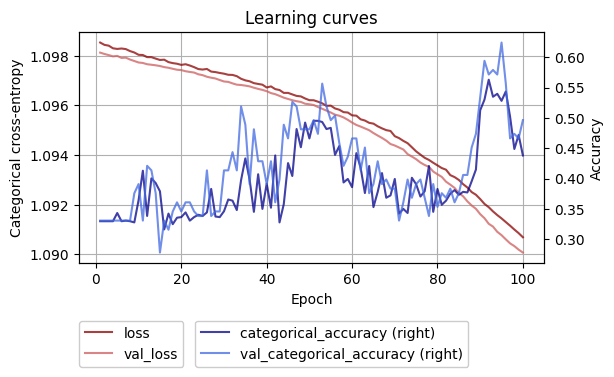

In [12]:
# Architecture V1.1
cnn1_1 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_1")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_1.build(input_shape)
# Check network
cnn1_1.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_1 = cnn1_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Even after 100 epochs, the accuracy does not increase over 55% but has increased not stadly, and the loss decreases very slow.

### CNN1.2
We can try to improve the basic model by rescaling the data to the [0,1] range before we start the convolution process.

Model: "CNN-V1_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 18)      1368      
                                                                 
 activation_2 (Activation)   (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 18)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 48)        21648     
                                                                 
 activation_3 (Activation)   (None, 58, 58, 48)        0         
                                                          

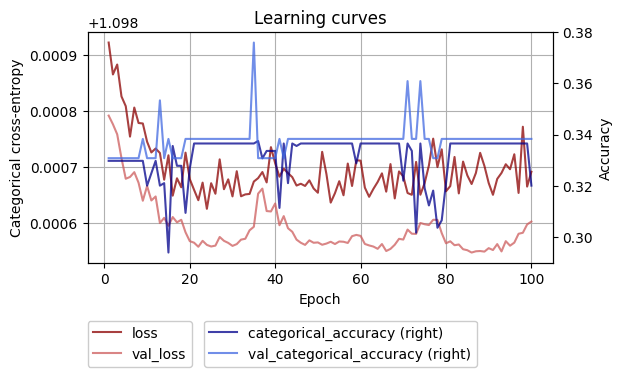

In [13]:
# Architecture V1.2
cnn1_2 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), # subsampling
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_2")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_2.build(input_shape)
# Check network
cnn1_2.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V2)
epochs = 100
history1_2 = cnn1_2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Adding rescaling does not improve the model, the accuracy dropped, and training or validation does not increase over 34%.

### CNN1.3
Therefore, we will add the augmentation we prepared previously. 

Model: "CNN-V1_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 18)      1368      
                                                                 
 activation_4 (Activation)   (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 18)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 58, 48)        216

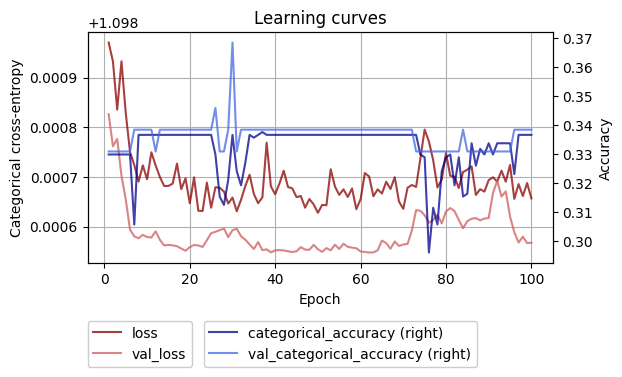

In [14]:
# Architecture V1.3
cnn1_3 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                    # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), # subsampling
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_3")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_3.build(input_shape)
# Check network
cnn1_3.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V3)
epochs = 100
history1_3 = cnn1_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

tf.get_logger().setLevel('ERROR')

The results need to improve

### CNN1.4
Trying other optimizer, like AdaGrad, that adjusts the learning rates of all model parameters on an individual basis by inversely scaling them with the square root of the sum of all historical squared gradient values. This method causes a more rapid decrease in learning rate for parameters with the highest partial derivative of loss, while those with smaller partial derivatives experience a relatively minor decrease in learning rate. As a result, the algorithm makes more significant progress in directions of parameter space with gentler slopes.

Model: "CNN-V1_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 124, 18)      1368      
                                                                 
 activation_6 (Activation)   (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 18)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 58, 58, 48)        216

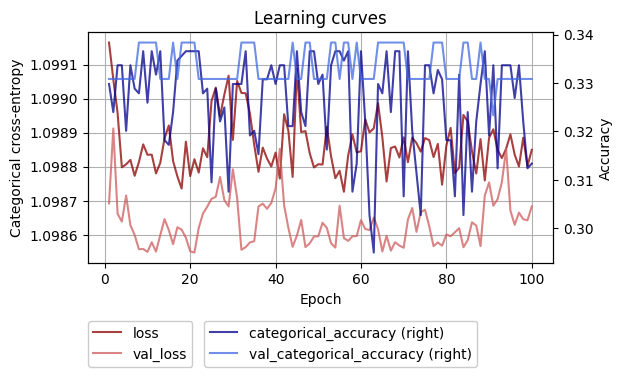

In [15]:
# Architecture V1.4
cnn1_4 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_4")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_4.build(input_shape)
# Check network
cnn1_4.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_4 = cnn1_4.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN1.5
The RMSProp optimizer, improves upon AdaGrad for nonconvex optimization problems by using an exponentially weighted moving average instead of the original gradient accumulation method. While AdaGrad is efficient in converging quickly when applied to convex functions, training a neural network with a nonconvex function may result in the learning trajectory passing through multiple structures before eventually reaching the minimum.

Model: "CNN-V1_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 124, 124, 18)      1368      
                                                                 
 activation_8 (Activation)   (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 62, 62, 18)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 58, 58, 48)        216

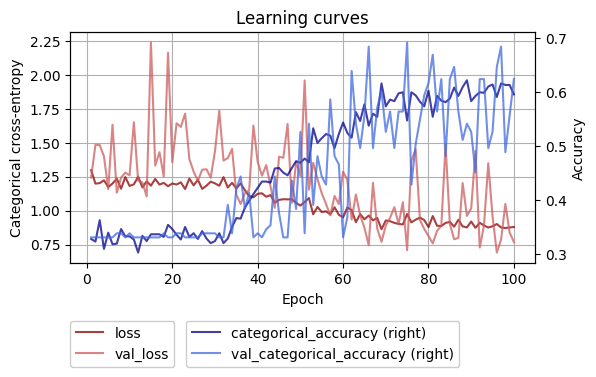

In [16]:
# Architecture V1.5
cnn1_5 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_5")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_5.build(input_shape)
# Check network
cnn1_5.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_5 = cnn1_5.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### +CNN1.6
Changing to Adam optimizer. Adam, another adaptive learning rate optimization algorithm named for "adaptive moments". Adam can be thought of as a variant of the combination of RMSProp and momentum, but with several key differences. First, Adam directly incorporates momentum as an exponential-weighted estimate of the first-order moment of the gradient, whereas the addition of momentum to RMSProp is typically done to the rescaled gradients, lacking a clear theoretical basis. Second, Adam includes bias corrections to account for the initialization of both the first-order and uncentered second-order moments at the origin. While RMSProp also uses an uncentered second-order moment estimate, it does not correct for bias, leading to potentially high bias early in training. Adam is generally considered robust to hyperparameter choices, although the default learning rate may need adjustment.

Model: "CNN-V1.6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 124, 124, 18)      1368      
                                                                 
 activation_10 (Activation)  (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 18)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 58, 58, 48)        216

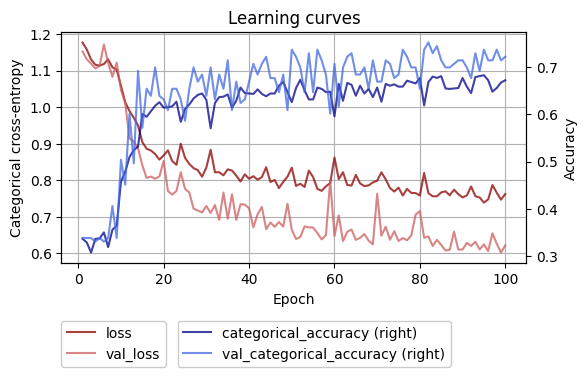

In [17]:
# Architecture V1.6
cnn1_6 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.6")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_6.build(input_shape)
# Check network
cnn1_6.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_6.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_6 = cnn1_6.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_6.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

The LeNet model works starts working well with Adam optimizer. Validation accuracy hight then training. The model is not overfitting. We got a categorical accuracy: 63,15% and AUROC: 80,91%.

### CNN1.7

Increasing the sample size of a batch can result in gradients that are more informative and less noisy. So we can try increase the batch size to 128.

Model: "CNN-V1.7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 124, 124, 18)      1368      
                                                                 
 activation_12 (Activation)  (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 62, 18)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 58, 58, 48)        216

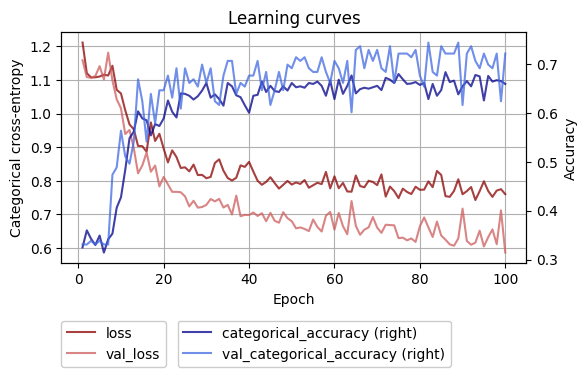

In [18]:
# Architecture V1.7
cnn1_7 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.7")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_7.build(input_shape)
# Check network
cnn1_7.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_7.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_7 = cnn1_7.fit(ds_train, epochs=epochs, validation_data=ds_validation, batch_size=256)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_7.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

It does not improve, and is a litle more irregular

### CNN1.8

Increasing the learning rate

Model: "CNN-V1.8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_6 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 124, 124, 18)      1368      
                                                                 
 activation_14 (Activation)  (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 62, 62, 18)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 58, 58, 48)        216

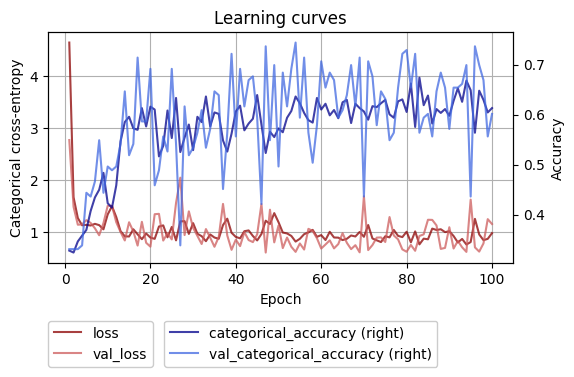

In [19]:
# Architecture V1.8
cnn1_8 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.8")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_8.build(input_shape)
# Check network
cnn1_8.summary()  

# Compiles the model for training.
learning_rate = 0.01 
cnn1_8.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_8 = cnn1_8.fit(ds_train, epochs=epochs, validation_data=ds_validation, batch_size=256)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_8.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN1.9

Decreasing the learning rate

Model: "CNN-V1.9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 124, 124, 18)      1368      
                                                                 
 activation_16 (Activation)  (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 18)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 58, 58, 48)        216

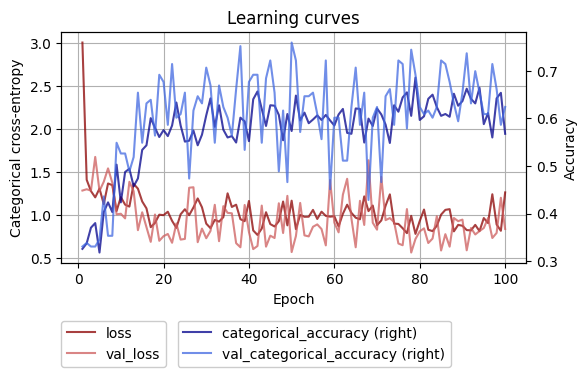

In [20]:
# Architecture V1.9
cnn1_9 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.9")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_9.build(input_shape)
# Check network
cnn1_9.summary()  

# Compiles the model for training.
learning_rate = 0.01 
cnn1_9.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_9= cnn1_9.fit(ds_train, epochs=epochs, validation_data=ds_validation, batch_size=256)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_9.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Version CNN1.6 seems to be the best for this LeNet Model: <br>
Batch size = 68, Learning Rate = 0.001 and Adam Optimizer <br>
But this model seems underfit; maybe we need a more complex model

### CNN 1.10

Changing Rescaling to BatchNormalization, from CNN1.6 version

Model: "CNN-V1.10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_18 (Conv2D)          (None, 124, 124, 18)      1368      
                                                                 
 activation_18 (Activation)  (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 62, 62, 18)       0         
 g2D)                                                            
                                                         

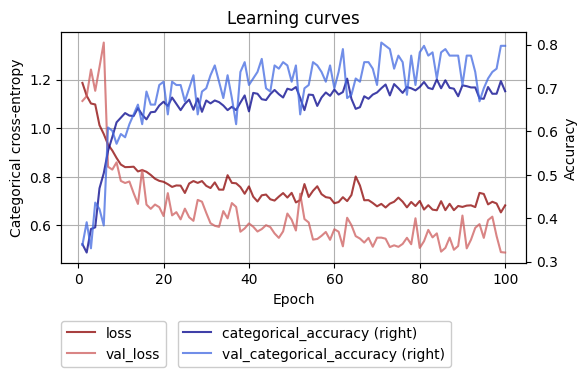

In [21]:
# Architecture V1.10
cnn1_10 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.BatchNormalization(),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.10")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_10.build(input_shape)
# Check network
cnn1_10.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_10.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 100
history1_10 = cnn1_10.fit(ds_train, epochs=epochs, validation_data=ds_validation, batch_size=256)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_10.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN2 - AlexNet
Here we will approach the AlexNet method by adding more layers (3 convolutional layers) and replacing the softmax in the convolution with the Relu that breaks up the linearity to increase the non-linearity of the images, employing the dropout rate regularization at starting point at 20%, to avoid overfitting and provide an efficient GPU implementation. We will start with the same initial parameters, SGD optimizer, a learning rate of 0.001, and 40 epochs.

###CNN2.1

Epoch 1/40
17/17 [==============================] - 9s 196ms/step - loss: 1.1280 - categorical_accuracy: 0.3540 - AUROC: 0.5165 - val_loss: 1.0958 - val_categorical_accuracy: 0.4887 - val_AUROC: 0.5992
Epoch 2/40
17/17 [==============================] - 3s 105ms/step - loss: 1.0639 - categorical_accuracy: 0.4255 - AUROC: 0.6114 - val_loss: 1.0929 - val_categorical_accuracy: 0.4361 - val_AUROC: 0.6130
Epoch 3/40
17/17 [==============================] - 3s 103ms/step - loss: 1.0384 - categorical_accuracy: 0.4826 - AUROC: 0.6557 - val_loss: 1.0891 - val_categorical_accuracy: 0.5714 - val_AUROC: 0.7018
Epoch 4/40
17/17 [==============================] - 3s 101ms/step - loss: 1.0181 - categorical_accuracy: 0.5058 - AUROC: 0.6835 - val_loss: 1.0854 - val_categorical_accuracy: 0.4135 - val_AUROC: 0.6676
Epoch 5/40
17/17 [==============================] - 5s 152ms/step - loss: 0.9904 - categorical_accuracy: 0.5232 - AUROC: 0.7120 - val_loss: 1.0780 - val_categorical_accuracy: 0.5113 - val_AURO

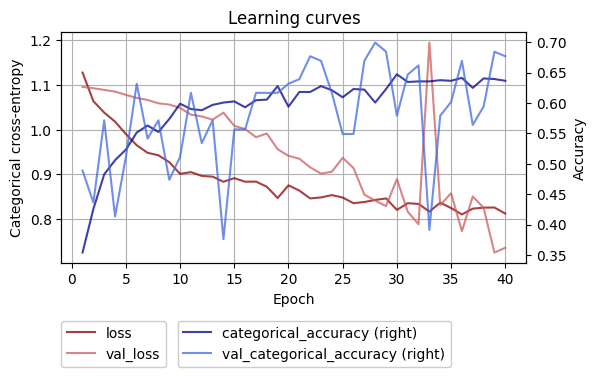

In [22]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V2.1
cnn2_1 = Sequential([# The input layer
                   layers.Input(input_shape),
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2.1")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn2_1.build(input_shape)
# Check network
cnn2_1.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 100
history2_1 = cnn2_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN2.2
We got a volatile model. Then, we will try the Adam optimizer, which works well in the LeNet Model.

Epoch 1/40
17/17 [==============================] - 7s 113ms/step - loss: 2.2767 - categorical_accuracy: 0.3549 - AUROC: 0.5250 - val_loss: 1.1093 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5277
Epoch 2/40
17/17 [==============================] - 3s 126ms/step - loss: 1.0592 - categorical_accuracy: 0.4362 - AUROC: 0.6187 - val_loss: 1.0948 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5413
Epoch 3/40
17/17 [==============================] - 4s 126ms/step - loss: 1.0155 - categorical_accuracy: 0.4787 - AUROC: 0.6700 - val_loss: 1.0606 - val_categorical_accuracy: 0.3459 - val_AUROC: 0.5815
Epoch 4/40
17/17 [==============================] - 3s 107ms/step - loss: 0.9920 - categorical_accuracy: 0.5271 - AUROC: 0.6906 - val_loss: 1.0535 - val_categorical_accuracy: 0.4361 - val_AUROC: 0.6628
Epoch 5/40
17/17 [==============================] - 3s 101ms/step - loss: 0.9912 - categorical_accuracy: 0.5309 - AUROC: 0.7109 - val_loss: 1.0486 - val_categorical_accuracy: 0.4286 - val_AURO

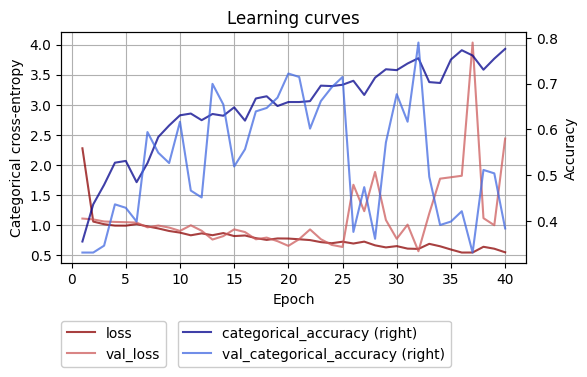

In [23]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V2.2
cnn2_2 = Sequential([# The input layer
                   layers.Input(input_shape),
                   # Data augmentation
                   augmentation,      
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_2")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn2_2.build(input_shape)
# Check network
cnn2_2.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 100
history2_2 = cnn2_2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

After 25 epochs starts to overfiting

### CNN2.3
We will try with RMSprop Optimizer

Epoch 1/40
17/17 [==============================] - 8s 146ms/step - loss: 25.4372 - categorical_accuracy: 0.3491 - AUROC: 0.5077 - val_loss: 1.0961 - val_categorical_accuracy: 0.3534 - val_AUROC: 0.5535
Epoch 2/40
17/17 [==============================] - 3s 105ms/step - loss: 1.0779 - categorical_accuracy: 0.4391 - AUROC: 0.6034 - val_loss: 1.1384 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5074
Epoch 3/40
17/17 [==============================] - 3s 106ms/step - loss: 1.1121 - categorical_accuracy: 0.4458 - AUROC: 0.5979 - val_loss: 1.0891 - val_categorical_accuracy: 0.3910 - val_AUROC: 0.5957
Epoch 4/40
17/17 [==============================] - 4s 183ms/step - loss: 1.1248 - categorical_accuracy: 0.3859 - AUROC: 0.5644 - val_loss: 1.2454 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4824
Epoch 5/40
17/17 [==============================] - 3s 104ms/step - loss: 1.1462 - categorical_accuracy: 0.4236 - AUROC: 0.5948 - val_loss: 1.0972 - val_categorical_accuracy: 0.3308 - val_AUR

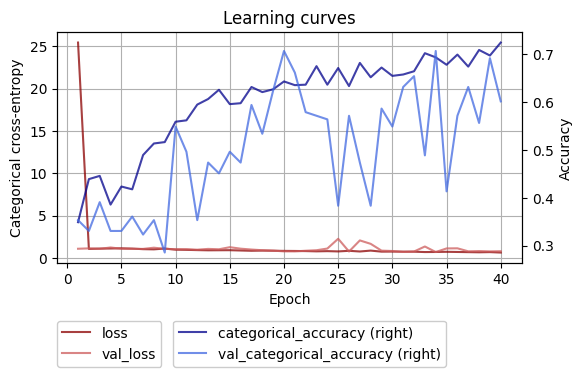

In [24]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V2.3
cnn2_3 = Sequential([# The input layer
                   layers.Input(input_shape), 
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_3")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn2_3.build(input_shape)
# Check network
cnn2_3.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 100
history2_3 = cnn2_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN2.4
In the AlexNet method, the RMSprop Optimizer works better, but it can improve the unstable, we will increase the dropout rate to 30% and decrease the epoch to 30.

Epoch 1/30
17/17 [==============================] - 7s 116ms/step - loss: 2.2999 - categorical_accuracy: 0.3143 - AUROC: 0.4692 - val_loss: 1.0984 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5216
Epoch 2/30
17/17 [==============================] - 3s 105ms/step - loss: 1.0964 - categorical_accuracy: 0.3839 - AUROC: 0.5591 - val_loss: 1.1062 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5035
Epoch 3/30
17/17 [==============================] - 3s 104ms/step - loss: 1.0947 - categorical_accuracy: 0.3530 - AUROC: 0.5468 - val_loss: 1.0916 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5556
Epoch 4/30
17/17 [==============================] - 3s 102ms/step - loss: 1.0730 - categorical_accuracy: 0.4497 - AUROC: 0.6271 - val_loss: 1.0817 - val_categorical_accuracy: 0.3233 - val_AUROC: 0.5670
Epoch 5/30
17/17 [==============================] - 3s 102ms/step - loss: 1.0315 - categorical_accuracy: 0.4739 - AUROC: 0.6527 - val_loss: 1.0779 - val_categorical_accuracy: 0.3835 - val_AURO

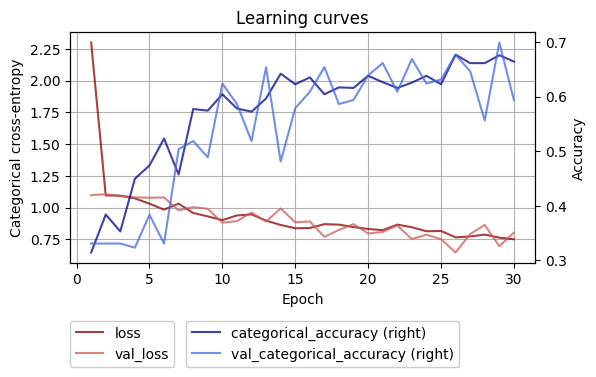

In [25]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.4
# Architecture V2.4
cnn2_4 = Sequential([# The input layer
                   layers.Input(input_shape),   
                   # Data augmentation
                   augmentation,   
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_4")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn2_4.build(input_shape)
# Check network
cnn2_4.summary() 

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 100
history2_4 = cnn2_4.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN2.5
Add BatchNormalization

Model: "CNN-V2_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 30, 30, 96)        0         
                                                          

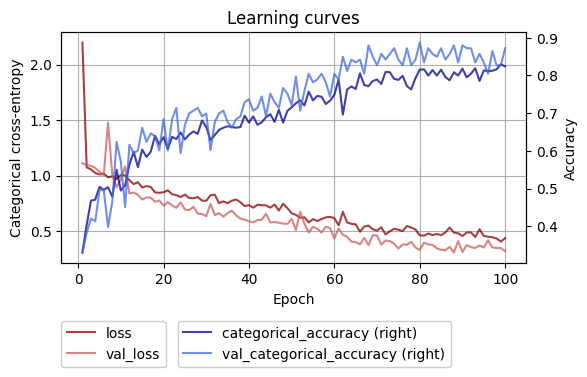

In [12]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.35
# Architecture V2.5
cnn2_5 = Sequential([# The input layer
                   layers.Input(input_shape), 
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.BatchNormalization(),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_5")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn2_5.build(input_shape)
# Check network
cnn2_5.summary() 

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 100
history2_5 = cnn2_5.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] # ["AUROC", "val_AUROC"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN3 - AlexNet simplified
Our model continue overfiting, we additional way to avoid it is to reduce the complexity of the model, we can do this by removing the last layer.

### CNN3.1

Epoch 1/30
17/17 [==============================] - 7s 166ms/step - loss: 4.3897 - categorical_accuracy: 0.4149 - AUROC: 0.5697 - val_loss: 1.0768 - val_categorical_accuracy: 0.3609 - val_AUROC: 0.5962
Epoch 2/30
17/17 [==============================] - 3s 95ms/step - loss: 1.0683 - categorical_accuracy: 0.4874 - AUROC: 0.6523 - val_loss: 1.1433 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5535
Epoch 3/30
17/17 [==============================] - 4s 121ms/step - loss: 1.0363 - categorical_accuracy: 0.5106 - AUROC: 0.6738 - val_loss: 1.0847 - val_categorical_accuracy: 0.4586 - val_AUROC: 0.6184
Epoch 4/30
17/17 [==============================] - 3s 95ms/step - loss: 1.0161 - categorical_accuracy: 0.5261 - AUROC: 0.6989 - val_loss: 1.0839 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.6113
Epoch 5/30
17/17 [==============================] - 3s 94ms/step - loss: 1.0529 - categorical_accuracy: 0.5280 - AUROC: 0.6932 - val_loss: 1.2673 - val_categorical_accuracy: 0.3383 - val_AUROC: 

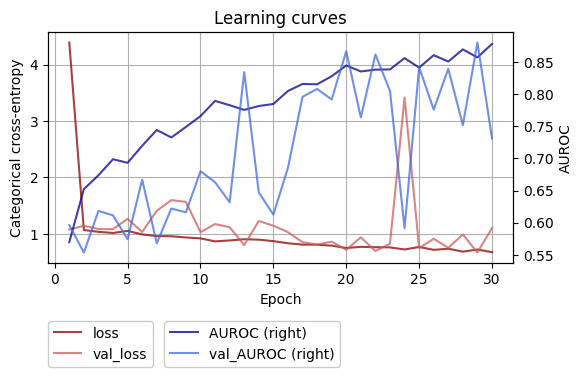

In [ ]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V3.1
cnn3_1 = Sequential([# The input layer
                   layers.Input(input_shape),  
                   # Data augmentation
                   augmentation,    
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3_1")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history3_1 = cnn3_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### +CNN3.2
Replaces the ``Rescaling`` layer with ``BatchNormalization``, allows to computing the z-scores from the pixel values.

Epoch 1/30
17/17 [==============================] - 6s 113ms/step - loss: 4.4713 - categorical_accuracy: 0.3627 - AUROC: 0.5252 - val_loss: 2.7678 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5269
Epoch 2/30
17/17 [==============================] - 5s 168ms/step - loss: 1.0711 - categorical_accuracy: 0.4507 - AUROC: 0.6297 - val_loss: 1.4887 - val_categorical_accuracy: 0.4586 - val_AUROC: 0.6190
Epoch 3/30
17/17 [==============================] - 3s 98ms/step - loss: 1.0664 - categorical_accuracy: 0.5203 - AUROC: 0.6754 - val_loss: 2.1842 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5543
Epoch 4/30
17/17 [==============================] - 3s 96ms/step - loss: 1.0442 - categorical_accuracy: 0.4787 - AUROC: 0.6607 - val_loss: 1.5637 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.6240
Epoch 5/30
17/17 [==============================] - 3s 98ms/step - loss: 1.0479 - categorical_accuracy: 0.5222 - AUROC: 0.6828 - val_loss: 1.4745 - val_categorical_accuracy: 0.3985 - val_AUROC: 

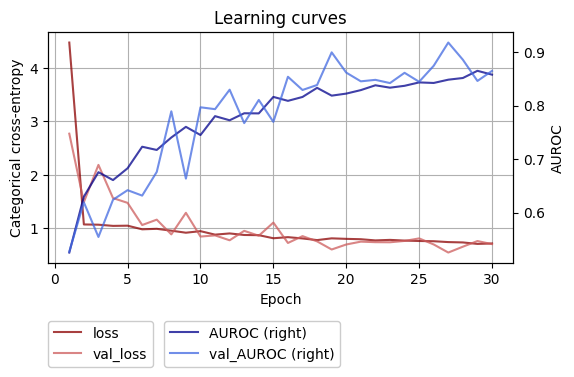

In [ ]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V3.2
cnn3_2 = Sequential([# The input layer
                   layers.Input(input_shape), 
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.2")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history3_2 = cnn3_2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN3.3
Dropout rate 20%, delete regularization L2 and 20 epoch.

Epoch 1/20
17/17 [==============================] - 7s 180ms/step - loss: 5.8659 - categorical_accuracy: 0.3839 - AUROC: 0.5496 - val_loss: 1.3889 - val_categorical_accuracy: 0.4586 - val_AUROC: 0.6140
Epoch 2/20
17/17 [==============================] - 3s 97ms/step - loss: 1.0879 - categorical_accuracy: 0.4961 - AUROC: 0.6582 - val_loss: 1.4146 - val_categorical_accuracy: 0.4060 - val_AUROC: 0.6384
Epoch 3/20
17/17 [==============================] - 3s 100ms/step - loss: 1.0386 - categorical_accuracy: 0.5184 - AUROC: 0.6911 - val_loss: 1.8624 - val_categorical_accuracy: 0.4662 - val_AUROC: 0.6328
Epoch 4/20
17/17 [==============================] - 3s 119ms/step - loss: 1.0235 - categorical_accuracy: 0.5174 - AUROC: 0.6867 - val_loss: 1.3141 - val_categorical_accuracy: 0.4812 - val_AUROC: 0.6643
Epoch 5/20
17/17 [==============================] - 3s 102ms/step - loss: 0.9751 - categorical_accuracy: 0.5348 - AUROC: 0.7142 - val_loss: 1.0340 - val_categorical_accuracy: 0.5338 - val_AUROC

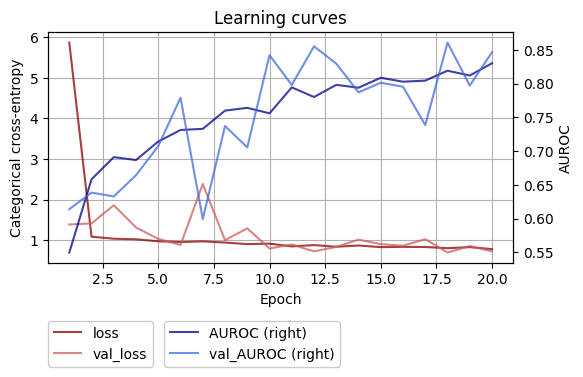

In [ ]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V3.3
cnn3_3 = Sequential([# The input layer
                   layers.Input(input_shape), 
                   # Data augmentation
                   augmentation,      
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.3")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 20
history3_3 = cnn3_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN3.4
20% dropout_rate, L2 regularization, 30 epochs

Epoch 1/30
17/17 [==============================] - 6s 135ms/step - loss: 5.4674 - categorical_accuracy: 0.3598 - AUROC: 0.5414 - val_loss: 2.1101 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4907
Epoch 2/30
17/17 [==============================] - 4s 113ms/step - loss: 1.0762 - categorical_accuracy: 0.4468 - AUROC: 0.6197 - val_loss: 2.1613 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5618
Epoch 3/30
17/17 [==============================] - 3s 99ms/step - loss: 1.0129 - categorical_accuracy: 0.5068 - AUROC: 0.6852 - val_loss: 1.0195 - val_categorical_accuracy: 0.5714 - val_AUROC: 0.7249
Epoch 4/30
17/17 [==============================] - 3s 101ms/step - loss: 1.0126 - categorical_accuracy: 0.5338 - AUROC: 0.7036 - val_loss: 2.0973 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5739
Epoch 5/30
17/17 [==============================] - 4s 168ms/step - loss: 0.9858 - categorical_accuracy: 0.5358 - AUROC: 0.7105 - val_loss: 1.8438 - val_categorical_accuracy: 0.3233 - val_AUROC

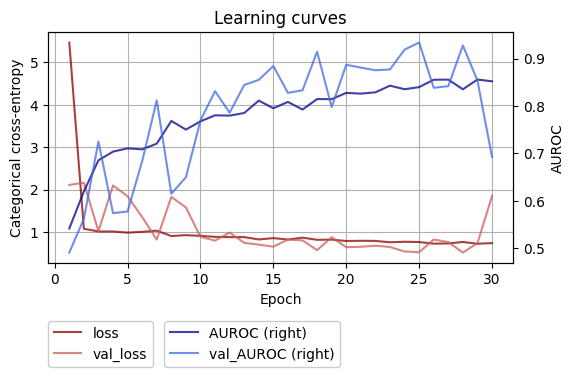

In [ ]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V3.4
cnn3_4 = Sequential([# The input layer
                   layers.Input(input_shape),
                   # Data augmentation
                   augmentation,       
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.4")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history3_4 = cnn3_4.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN3.5
Learning rate 0.0001

Epoch 1/30
17/17 [==============================] - 6s 164ms/step - loss: 1.3947 - categorical_accuracy: 0.4516 - AUROC: 0.6132 - val_loss: 1.3765 - val_categorical_accuracy: 0.4060 - val_AUROC: 0.6046
Epoch 2/30
17/17 [==============================] - 3s 98ms/step - loss: 0.9670 - categorical_accuracy: 0.5426 - AUROC: 0.7283 - val_loss: 1.5396 - val_categorical_accuracy: 0.3459 - val_AUROC: 0.5764
Epoch 3/30
17/17 [==============================] - 3s 97ms/step - loss: 0.9707 - categorical_accuracy: 0.5348 - AUROC: 0.7193 - val_loss: 1.0564 - val_categorical_accuracy: 0.4211 - val_AUROC: 0.6636
Epoch 4/30
17/17 [==============================] - 3s 97ms/step - loss: 0.9391 - categorical_accuracy: 0.5706 - AUROC: 0.7473 - val_loss: 0.9260 - val_categorical_accuracy: 0.6391 - val_AUROC: 0.7764
Epoch 5/30
17/17 [==============================] - 3s 120ms/step - loss: 0.9166 - categorical_accuracy: 0.5899 - AUROC: 0.7577 - val_loss: 1.0417 - val_categorical_accuracy: 0.3459 - val_AUROC: 

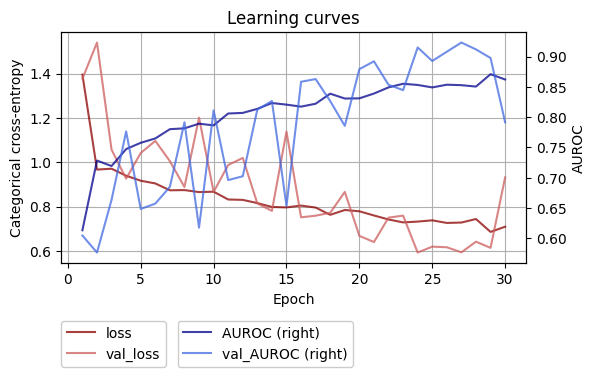

In [ ]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V3.5
cnn3_5 = Sequential([# The input layer
                   layers.Input(input_shape),
                   # Data augmentation
                   augmentation,       
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.5")

# Compiles the model for training.
learning_rate = 0.0001  
cnn3_5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history3_5 = cnn3_5.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## VGG

VGG (...). Defining a function to automatize neural architecture. Add a function block_vgg() function. The classification head is regularized/simplified with the GlobalMaxPooling2D() layer. To resemble the VGG16 variant, use vgg_blocks = ((2, 64, False), (2, 128, False), (2, 256, True), (2, 512, True), (2, 512, True)).

In [ ]:
def block_vgg(conv_layers, filters, conv1x1=True, batch_norm=True, seed=0):
    block = Sequential()
    for l in range(conv_layers + conv1x1):
        block.add(layers.Conv2D(filters, 
                                kernel_size=1 if l==conv_layers else 3, padding="same",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)))
        if batch_norm:
            block.add(layers.BatchNormalization())                         
        block.add(layers.Activation("relu"))
    
    block.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return block

compile the model, train it, creates a pandas.DataFrame from history dictionary and plots the learning curves.

### +VGG1.1

Model: "VGG-V1.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_16 (Bat  (64, 128, 128, 3)        12        
 chNormalization)                                                
                                                                 
 sequential (Sequential)     (64, 64, 64, 32)          10400     
                                                                 
 sequential_1 (Sequential)   (64, 32, 32, 64)          55936     
                                                                 
 sequential_2 (Sequential)   (64, 16, 16, 128)         239488    
                                                                 
 global_max_pooling2d (Globa  (64, 128)                0         
 lMaxPooling2D)                                                  
                                                                 
 dropout_10 (Dropout)        (64, 128)                 0  

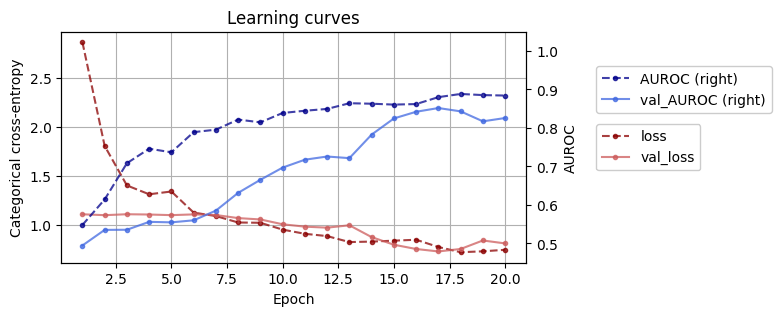

In [ ]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_1 = ((2, 32, False), (2, 64, False), (2, 128, True)) 
# Create CNN
vgg1_1 = Sequential(layers.BatchNormalization(), name="VGG-V1.1")
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_1:
    vgg1_1.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
# Define the classification head
vgg1_1.add(layers.GlobalMaxPooling2D())
vgg1_1.add(layers.Dropout(0.2))
vgg1_1.add(layers.Dense(units=3, activation="softmax",
                      kernel_initializer=initializers.GlorotNormal(seed=seed)))
# Build the DAG 
vgg1_1.build(input_shape)
# Check model
vgg1_1.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    vgg1_1.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. Trains the model
    epochs = 20
    history1_1 = vgg1_1.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=2)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. Creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history1_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# 4. Plots the learning curves
secondary_y = ["AUROC", "val_AUROC"]    # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y, 
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves", 
                  style=[".--", ".-"]*3,
                  color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                          alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
#ax.right_ax.legend(loc=(0.25, -0.65), framealpha=1.0)
ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
#ax.legend(loc=(0, -0.65), framealpha=1.0)
ax.legend(loc=(1.15, 0.40), framealpha=1.0)
plt.show()

### VGG1.2
Adding more feature detectors

Model: "VGG-V1_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 sequential (Sequential)     (64, 64, 64, 64)          39232     
                                                                 
 sequential_1 (Sequential)   (64, 32, 32, 128)         222464    
                                                                 
 sequential_2 (Sequential)   (64, 16, 16, 256)         954112    
                                                                 
 global_max_pooling2d (Globa  (64, 256)                0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (64, 256)                 0  

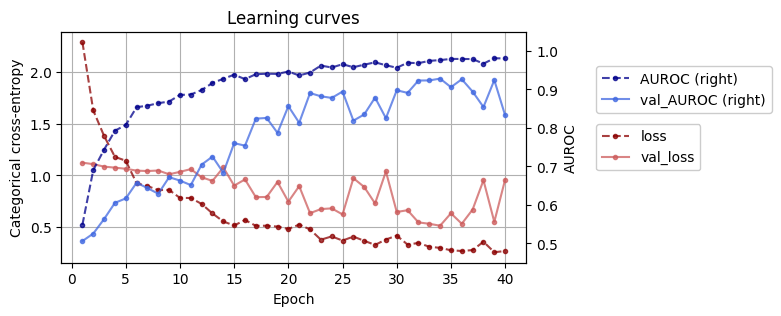

In [ ]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_2 = ((2, 64, False), (2, 128, False), (2, 256, True)) 
# Create CNN
vgg1_2 = Sequential(layers.BatchNormalization(), name="VGG-V1_2")
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_2:
    vgg1_2.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
# Define the classification head
vgg1_2.add(layers.GlobalMaxPooling2D())
vgg1_2.add(layers.Dropout(0.2))
vgg1_2.add(layers.Dense(units=3, activation="softmax",
                      kernel_initializer=initializers.GlorotNormal(seed=seed)))
# Build the DAG 
vgg1_2.build(input_shape)
# Check model
vgg1_2.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    vgg1_2.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. Trains the model
    epochs = 40
    history1_2 = vgg1_2.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=2)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. Creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history1_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# 4. Plots the learning curves
secondary_y = ["AUROC", "val_AUROC"] #["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y, 
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves", 
                  style=[".--", ".-"]*3,
                  color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                          alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
#ax.right_ax.legend(loc=(0.25, -0.65), framealpha=1.0)
ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
#ax.legend(loc=(0, -0.65), framealpha=1.0)
ax.legend(loc=(1.15, 0.40), framealpha=1.0)
plt.show()

### VGG1.3
Add more ...

Model: "VGG-V1_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 sequential_3 (Sequential)   (64, 64, 64, 32)          10400     
                                                                 
 sequential_4 (Sequential)   (64, 32, 32, 64)          55936     
                                                                 
 sequential_5 (Sequential)   (64, 16, 16, 128)         239488    
                                                                 
 sequential_6 (Sequential)   (64, 8, 8, 256)           954112    
                                                                 
 global_max_pooling2d_1 (Glo  (64, 256)                0         
 balMaxPooling2D)                                         

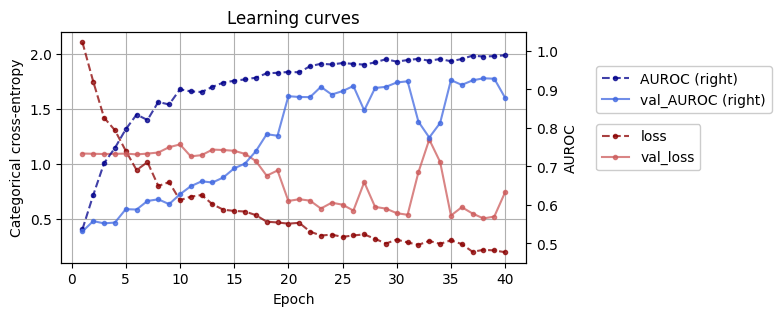

In [ ]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_3 = ((2, 32, False), (2, 64, False), (2, 128, True), (2, 256, True)) 
# Create CNN
vgg1_3 = Sequential(layers.BatchNormalization(), name="VGG-V1_3")
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_3:
    vgg1_3.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
# Define the classification head
vgg1_3.add(layers.GlobalMaxPooling2D())
vgg1_3.add(layers.Dropout(0.2))
vgg1_3.add(layers.Dense(units=3, activation="softmax",
                      kernel_initializer=initializers.GlorotNormal(seed=seed)))
# Build the DAG 
vgg1_3.build(input_shape)
# Check model
vgg1_3.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    vgg1_3.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. Trains the model
    epochs = 40
    history1_3 = vgg1_3.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=2)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. Creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history1_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# 4. Plots the learning curves
secondary_y = ["AUROC", "val_AUROC"] #["accuracy", "val_accuracy"]  
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y, 
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves", 
                  style=[".--", ".-"]*3,
                  color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                          alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
#ax.right_ax.legend(loc=(0.25, -0.65), framealpha=1.0)
ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
#ax.legend(loc=(0, -0.65), framealpha=1.0)
ax.legend(loc=(1.15, 0.40), framealpha=1.0)
plt.show()

## Functional AI (standard)

## CNN4.1

In [ ]:
# 1. create an input node using the tf.keras.Input class (which is different from tf.keras.layers.Input). 
# The input node instantiates a symbolic tensor-like object that allows building a Keras model just by knowing the inputs and outputs of the model
inputs = layers.Input(shape=input_shape[1:])  
# 2. compute the z-scores from the batch
x = layers.BatchNormalization()(inputs)
# 3. specify the convolutional backbone for learning representations
x = layers.Conv2D(filters=32, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x) 
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# 4. perform global pooling to reduce a HxWxC cuboid of features into a C-dimensional vector
x = layers.GlobalMaxPooling2D()(x)
# 5. specify the classifier
y_pred = layers.Dense(units=3, activation="softmax", 
                      kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
# 6. create final model from inputs and outputs using the tf.keras.Model class
cnn4_1 = Model(inputs, y_pred)
# Check network
cnn4_1.summary()  # alternatively use tf.keras.utils.plot_model(cnn1, show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 batch_normalization_62 (Bat  (None, 128, 128, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_91 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_63 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 activation_84 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 63, 63, 32)       0     

Epoch 1/30
17/17 [==============================] - 6s 155ms/step - loss: 2.0288 - categorical_accuracy: 0.3985 - AUROC: 0.5759 - val_loss: 2.0545 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5922
Epoch 2/30
17/17 [==============================] - 3s 107ms/step - loss: 0.9506 - categorical_accuracy: 0.5870 - AUROC: 0.7600 - val_loss: 1.8435 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.6000
Epoch 3/30
17/17 [==============================] - 3s 102ms/step - loss: 0.7752 - categorical_accuracy: 0.6712 - AUROC: 0.8378 - val_loss: 1.5861 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.6382
Epoch 4/30
17/17 [==============================] - 4s 153ms/step - loss: 0.6805 - categorical_accuracy: 0.7137 - AUROC: 0.8755 - val_loss: 1.8708 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.6503
Epoch 5/30
17/17 [==============================] - 3s 105ms/step - loss: 0.6037 - categorical_accuracy: 0.7708 - AUROC: 0.9040 - val_loss: 0.9223 - val_categorical_accuracy: 0.4887 - val_AURO

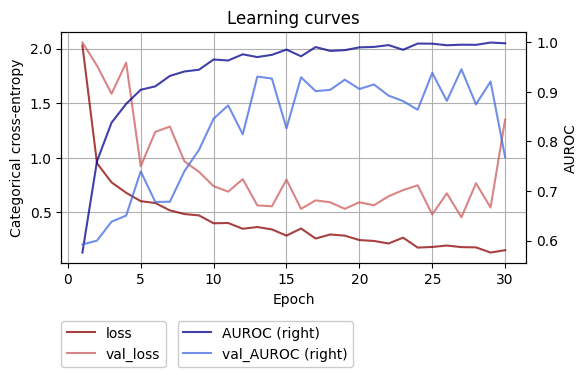

In [ ]:
# Compiles the model for training.
learning_rate = 0.001  
cnn4_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history4_1 = cnn4_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history4_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## Functional (object-oriented)

## +CNN5.1

In [ ]:
class CustomCNN(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Z-scores 
        self.zscores = layers.BatchNormalization()
        # Convolutional layers (with learnable parameters)
        self.conv32 = layers.Conv2D(filters=32, kernel_size=3, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv64 = layers.Conv2D(filters=64, kernel_size=3, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed))        
        # Batch normalization layers (with learnable parameters)
        self.bn32 = layers.BatchNormalization()                          
        self.bn64 = layers.BatchNormalization()
        # Classifier's head
        self.dense1 = layers.Dense(units=3, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers (define only once)
        self.relu = layers.Activation("relu")
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        # Orderly flows the inputs through the network's components
        x = self.zscores(inputs)
        x = self.conv32(x)
        x = self.bn32(x)
        x = self.relu(x)
        x = self.maxpool2x2(x)
        x = self.conv64(x)
        x = self.bn64(x)
        x = self.relu(x)
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of the CustomCNN class
cnn5_1 = CustomCNN(seed=seed)
# Builds the DAG 
cnn5_1.build(input_shape)
# Check the network
cnn5_1.summary()

Model: "custom_cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_65 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_93 (Conv2D)          multiple                  896       
                                                                 
 conv2d_94 (Conv2D)          multiple                  18496     
                                                                 
 batch_normalization_66 (Bat  multiple                 128       
 chNormalization)                                                
                                                                 
 batch_normalization_67 (Bat  multiple                 256       
 chNormalization)                                                
                                                      

Epoch 1/30
17/17 [==============================] - 6s 136ms/step - loss: 1.9689 - categorical_accuracy: 0.4536 - AUROC: 0.6064 - val_loss: 2.4887 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5933
Epoch 2/30
17/17 [==============================] - 3s 130ms/step - loss: 0.8967 - categorical_accuracy: 0.6170 - AUROC: 0.7869 - val_loss: 3.3036 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5702
Epoch 3/30
17/17 [==============================] - 4s 122ms/step - loss: 0.7476 - categorical_accuracy: 0.6876 - AUROC: 0.8499 - val_loss: 2.3609 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.6310
Epoch 4/30
17/17 [==============================] - 3s 102ms/step - loss: 0.6459 - categorical_accuracy: 0.7389 - AUROC: 0.8889 - val_loss: 1.7929 - val_categorical_accuracy: 0.3459 - val_AUROC: 0.6300
Epoch 5/30
17/17 [==============================] - 3s 102ms/step - loss: 0.6089 - categorical_accuracy: 0.7563 - AUROC: 0.9018 - val_loss: 1.4963 - val_categorical_accuracy: 0.3684 - val_AURO

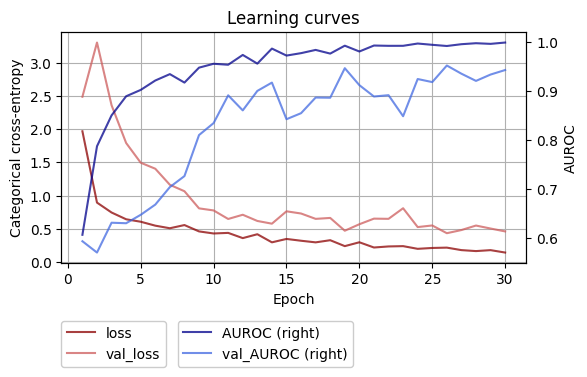

In [ ]:
# Compiles the model for training.
learning_rate = 0.001  
cnn5_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history5_1 = cnn5_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history5_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## ResNet using the Functional API - Standard residual block

In [ ]:
class ResidualBlock(tf.keras.Model):  
    def __init__(self, in_filters, expand=1, downsample=False, seed=0):
        super().__init__()       
        self.expand = expand
        self.downsample = downsample
        self.conv1 = layers.Conv2D(in_filters, kernel_size=3, padding="same",
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv2 = layers.Conv2D(in_filters*self.expand, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        #if self.downsample:
        #    self.conv1x1 = layers.Conv2D(filters, kernel_size=1, strides=2,
        #                                 kernel_initializer=initializers.GlorotNormal(seed=seed))
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=seed))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)           
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)
        return x   
 

## ResNet using the Functional API - Bottleneck residual block

In [ ]:
class BottleneckBlock(tf.keras.Model):  
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample        
        self.expand = expand
        self._squeeze = in_filters//squeeze    
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=seed))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)        
        return x        

## ResNet using the Functional API - CustomResNet

## +CNN6.1

In [ ]:
class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # # Z-scores 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed)        
        self.conv3 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)   
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=3, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn6_1 = CustomResNet(seed=seed)
# Builds the DAG 
cnn6_1.build(input_shape)
# Check the network
cnn6_1.summary()
# Set control flag to True
train = True

Model: "custom_res_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_24 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_25 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block (Bottlenec  multiple                 58752     
 kBlock)                                                         
                                                                 
 bottleneck_block_1 (Bottlen  multiple                 96384     
 eckBlock)                                        

Epoch 1/40
17/17 [==============================] - 7s 141ms/step - loss: 1.3597 - accuracy: 0.6422 - AUROC: 0.5706 - val_loss: 1.2709 - val_accuracy: 0.4937 - val_AUROC: 0.5184
Epoch 2/40
17/17 [==============================] - 4s 174ms/step - loss: 0.9491 - accuracy: 0.7044 - AUROC: 0.7150 - val_loss: 1.0982 - val_accuracy: 0.4987 - val_AUROC: 0.5603
Epoch 3/40
17/17 [==============================] - 3s 98ms/step - loss: 0.7997 - accuracy: 0.7411 - AUROC: 0.7871 - val_loss: 1.1410 - val_accuracy: 0.5464 - val_AUROC: 0.5656
Epoch 4/40
17/17 [==============================] - 3s 98ms/step - loss: 0.7063 - accuracy: 0.7801 - AUROC: 0.8259 - val_loss: 1.0837 - val_accuracy: 0.5664 - val_AUROC: 0.5881
Epoch 5/40
17/17 [==============================] - 3s 96ms/step - loss: 0.6351 - accuracy: 0.7950 - AUROC: 0.8583 - val_loss: 1.1126 - val_accuracy: 0.5439 - val_AUROC: 0.5774
Epoch 6/40
17/17 [==============================] - 4s 157ms/step - loss: 0.5935 - accuracy: 0.8040 - AUROC: 0.87

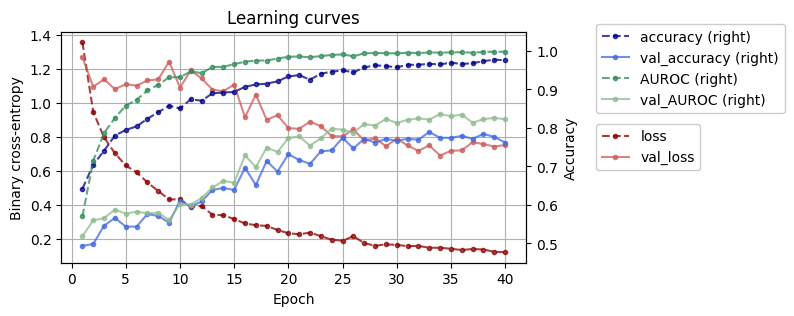

In [ ]:
if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    cnn6_1.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. trains the model
    epochs = 40
    history6_1 = cnn6_1.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=1)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history6_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# 4. plots the learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy", "AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y, 
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves", 
                  style=[".--", ".-"]*3,
                  color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                         alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(1.15, 0.40), framealpha=1.0)
plt.show()